In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import os
#import seaborn as sns

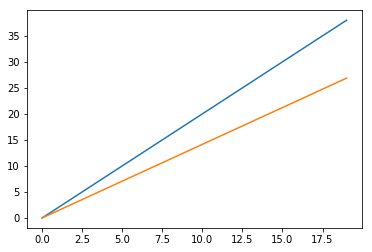

In [5]:
t = np.arange(0,20)

plt.plot(t, 2*t)
plt.plot(t, np.sqrt(t**2 + t**2))

In [4]:
np.sqrt(t**2 + t**2)

array([ 0.        ,  1.41421356,  2.82842712,  4.24264069,  5.65685425,
        7.07106781,  8.48528137,  9.89949494, 11.3137085 , 12.72792206,
       14.14213562, 15.55634919, 16.97056275, 18.38477631, 19.79898987,
       21.21320344, 22.627417  , 24.04163056, 25.45584412, 26.87005769])

In [19]:
from utils.pipeline import run_matches_discovery, discovery_pipeline
from utils.pipeline_wrappers import gen_expname, run_until_coverage_th, try_run_exp, cv_experiment, monitor_callback, grid_exp
from utils.feature_utils import op_100, get_feats, get_seq_names, get_dh_feats_wrap, load_feats
from utils.helper_fncs import load_json
from utils.skopt_tune import TunerSkopt
from copy import deepcopy

In [23]:
def set_optim_params(params, xopt):
    for i, key in enumerate(params['tune']['keys']):
        val = xopt[i]
        if isinstance(val, float): val = round(val,4)
        params['disc'][key] = val

def run_for_set(cvset, feat_loader, params):
    # get scores for set_x (params_optim)
    signers = ['Signer0{}'.format(x) for x in signers_per_set[cvset]]
    
    scores_dict = dict()
    for params['CVset'] in [cvset]:
#    for params['CVset'] in  signers:
        seq_names = get_seq_names(params)
        
        feats_dict = feat_loader(seq_names, params['featype'], params)
        
        tmp_feats = {key: feats_dict[key] for key in seq_names}
        scores = cv_experiment(seq_names, feats_dict, params, nfold = 5)
        
#        while (scores['ned'] > 99) :
#            params['disc']['top_delta'] += 0.01
#            scores = cv_experiment(seq_names, feats_dict, params, nfold = 5)
        
        scores_dict[params['CVset']] = scores
        params['disc']['top_delta'] = 0.05

    return scores_dict

In [24]:
cvsets = set(['A','B','C'])
signers_per_set = {'A': [4,8,9], 'B':[2,5,7], 'C':[1,3,6]}

alg_type = 'sdtw'
params = load_json(full_path='/home/korhan/Dropbox/config/{}.json'.format(alg_type))
params

{'CVroot': '/home/korhan/Dropbox/CVfolds',
 'clustering': {'cost_thr': 0.001, 'method': 'pairwise', 'olapthr_m': 0.25},
 'config_file': '/home/korhan/Dropbox/config/config_phoenix.json',
 'count': 81,
 'covth': 10,
 'disc': {'L': 6,
  'diag_olap': False,
  'diag_thr': 0.7,
  'end_cut': 0,
  'extend_r': 4,
  'loss_func': 'cosine',
  'w': 20},
 'exp_root': '/home/korhan/Desktop/tez/sdtw_exps',
 'feats_root': '/home/korhan/Desktop/tez/dataset/features',
 'lr': 0.8,
 'maxth': 0.7,
 'mult': 1.1,
 'njobs': 2,
 'patience': 30,
 'disc_method': 'sdtw',
 'dataset': 'phoenix',
 'tune': {'keys': ['L', 'extend_r'],
  'minimizer': 'gp',
  'n_split': 5,
  'stop_margin': 0.02,
  'stopper_patience': 5}}

In [32]:
# change desired params here
params['tune']['keys'] = [ 'L']
params['tune']['minimizer'] = 'gp'
params['tune']['stopper_patience'] = 3
params['tune']['stop_margin'] = 4
params['tune']['n_split'] = 10
params['disc']['olapthr_m'] = 0.25
params['disc']['extend_r'] = 0
params['disc']['loss_func'] = 'euclid'
params['tune']['n_split'] = 10

# params['clustering']['olapthr_m'] = 0.2

"""params['clustering'] = {
                       'method': 'modularity',
                       'cost_thr': 0.01,
                       'peak_thr': 0.5,
                       'modularity_thr': 0,
                       'clus_alg': 'fastgreedy',
                       'min_cluster_size':2,
                       'dedupthr': 0.5,
                       }
"""
"""
params['clustering'] = {
                        'method': 'zr17',
                        'cost_thr': 0.01,
                        'olapthr': 0.5,
                        'min_ew': 0,
                        'dtwth':0.1,
                        'dedupthr': 0.5,
                        }
"""


params['featype'] = 'op100'
#params['featype'] = 'c3_right_PCA40'

params_default = deepcopy(params)

# load related features
params['CVset'] = 'A'
seq_names = get_seq_names(params)
feats_dict = load_feats(seq_names, params['featype'], params)
feats_dict[seq_names[0]].shape

(151, 100)

In [33]:
all_stats = dict()
tuners = dict()

for devset in sorted(cvsets):    
#for devset in ['C']:    
    testsets = sorted(cvsets - set(devset))
    
    # load related features
    params['CVset'] = devset
    seq_names = get_seq_names(params)
    feats_dict = load_feats(seq_names, params['featype'], params)
   
    # paramtune on devset
    print('=== Running Paramtune on Devset {} ==='.format(devset))
    tuner = TunerSkopt(seq_names, feats_dict, params)
    tuner.prepare(load_checkpoint=True)
#     if devset == 'B':
    xopt, score_min = tuner.run(n_calls=11)
    tuners[devset] = tuner
    print('=== Paramtune completed with min score {} ==='.format(score_min))
    set_optim_params(params, xopt)
    
    params['tune']['n_split'] = 5
    # re-run to get full stats
    stats = [run_for_set(setx, load_feats, params) for setx in sorted(cvsets)]
    
    all_stats[devset] = stats

    # re-set params
    params = deepcopy(params_default)
    
    
# average dev, test scores

   

=== Running Paramtune on Devset A ===
Iteration No: 1 started. Searching for the next optimal point.
Checkpoint /home/korhan/Dropbox/tez/checkpoints/sdtw/gp_A_op100_L.pkl with score 75.03 loaded !!!
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.0104
Function value obtained: 75.0320
Current minimum: 75.0320
=== Paramtune completed with min score 75.03200000000001 ===
sdtw_A_op100_fold1-5
sdtw_A_op100_L11_diag_olapFalse_diag_thr0.7_end_cut0_extend_r0_loss_funceuclid_w20_olapthr_m0.25
Running first 341 files, for 81th experiment
0.001


KeyboardInterrupt: 

In [1]:
params

NameError: name 'params' is not defined

In [9]:
# res = tuners['A'].s
def top_n_results(res, n):
    return res.func_vals[np.argsort(res.func_vals)][:n], [res.x_iters[i] for i in np.argsort(res.func_vals)][:n]

In [ ]:
gbrt 

49.76 12, 12, 0.004111710628230209, 0.2341966457815864
44.34 14, 5, 0.17923047703889403, 0.4431
46.21 14, 10, 0.1880803340510649, 0.5945

gp

49.25 12, 12, 9.855643339381123e-05, 0.3148
43.11 15, 6, 0.16177853419464064, 0.3387
42.93 15, 5, 0.15589747266122583, 0.1

In [24]:
top_n_results(tuners['A'].result,15)

(array([37.86 , 37.86 , 37.86 , 39.198, 39.63 , 41.054, 41.53 , 41.792,
        44.304, 44.602, 44.744, 45.402, 46.49 , 49.138]),
 [[14, 1],
  [14, 1],
  [14, 1],
  [15, 1],
  [13, 3],
  [9, 4],
  [9, 2],
  [11, 1],
  [6, 4],
  [4, 6],
  [13, 6],
  [5, 7],
  [6, 7],
  [15, 7]])

In [25]:
top_n_results(tuners['B'].result,10)

(array([49.822, 49.822, 50.694, 51.932, 53.078, 53.54 , 54.674, 55.226,
        55.876, 57.002]),
 [[11, 1],
  [11, 1],
  [9, 2],
  [6, 4],
  [14, 1],
  [9, 4],
  [5, 7],
  [6, 7],
  [4, 6],
  [13, 3]])

In [12]:
top_n_results(tuners['C'].result,30)

(array([46.592, 46.592, 46.592, 48.41 , 49.748, 51.408, 52.71 , 54.858,
        56.75 , 57.014, 58.968, 59.702, 60.818, 60.828]),
 [[14, 1],
  [14, 1],
  [14, 1],
  [15, 1],
  [13, 3],
  [11, 1],
  [9, 4],
  [9, 2],
  [13, 6],
  [6, 4],
  [6, 7],
  [5, 7],
  [15, 7],
  [4, 6]])

In [78]:
dflist = []
for devset, stats in all_stats.items():
    dflist.append(pd.DataFrame([{**{'devset':devset},**{'set':key}, **item} 
                                for sublist in stats for key,item in sublist.items()]))
    
df = pd.concat(dflist, ignore_index=True)
df

,L,boundary_F,boundary_F_std,boundary_P,boundary_P_std,boundary_R,boundary_R_std,coverage,coverageNS,coverageNS_f,...,token_R,token_R_std,top_delta,type_F,type_F_std,type_P,type_P_std,type_R,type_R_std,w
0,14,27.9720,0.519394,100.0,0.0,16.2760,0.350685,9.6040,10.054,14.0720,...,3.7040,0.327613,NaN,18.946,1.187742,44.386,2.153841,12.0640,0.938952,20
1,14,27.7400,1.667888,100.0,0.0,16.1300,1.122675,9.4840,10.626,14.0900,...,4.0440,0.598857,0.05,16.708,2.245344,45.646,4.659027,10.2600,1.579335,20
2,14,26.5900,2.258849,100.0,0.0,15.3640,1.491653,9.4100,9.860,13.6180,...,3.1360,0.381025,0.05,14.472,2.644347,40.996,6.517809,8.7940,1.671715,20
3,14,24.8640,3.153209,100.0,0.0,14.2420,2.051943,8.5000,9.984,14.6760,...,1.5460,0.848045,0.05,5.668,2.739465,24.580,12.320862,3.2140,1.555130,20
4,14,27.6360,2.297331,100.0,0.0,16.0680,1.559686,9.5780,10.078,13.6640,...,3.1640,0.636498,0.05,20.056,1.241644,45.276,3.641831,12.8960,0.882910,20
5,14,31.9820,18.363011,100.0,0.0,20.3780,15.138817,12.6620,17.920,24.2700,...,1.2580,1.620299,0.05,2.776,2.691864,9.974,6.111573,1.6840,1.800703,20
6,14,26.9600,1.705242,100.0,0.0,15.6040,1.136653,9.2160,9.824,12.8160,...,3.3720,0.311721,0.05,19.672,3.176818,48.406,5.485693,12.3600,2.179507,20
7,14,26.1700,1.067661,100.0,0.0,15.0700,0.703847,9.5160,9.678,12.7140,...,2.5860,0.233838,0.05,11.914,0.734289,33.650,3.922773,7.2480,0.409780,20
8,14,26.4380,0.863753,100.0,0.0,15.2520,0.571244,9.2240,9.752,13.9780,...,3.4720,0.362519,0.05,22.906,2.329502,47.826,2.647741,15.0860,1.852857,20
9,14,26.4520,0.651974,100.0,0.0,15.2560,0.436898,9.3480,10.090,14.3160,...,3.3720,0.340103,0.05,20.448,2.232985,44.460,5.712219,13.2920,1.445898,20


In [79]:
df[['devset','set','L', 'extend_r','ned']].style.background_gradient(cmap='Blues')

,devset,set,L,extend_r,ned
0,A,A,14,1,68.844
1,A,Signer04,14,1,62.668
2,A,Signer08,14,1,69.376
3,A,Signer09,14,1,56.77
4,A,B,14,1,79.032
5,A,Signer02,14,1,77.24
6,A,Signer05,14,1,75.876
7,A,Signer07,14,1,55.41
8,A,C,14,1,72.048
9,A,Signer01,14,1,75.16


In [10]:
df[['devset','set','lmin','lmax','dim_fix','r','s','ned']].style.background_gradient(cmap='Blues')

/home/korhan/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,devset,set,lmin,lmax,dim_fix,r,s,ned
0,A,A,5.000000,10.000000,12.000000,0.200000,0.600000,50.590000
1,A,Signer04,5.000000,10.000000,12.000000,0.200000,0.600000,39.230000
2,A,Signer08,5.000000,10.000000,12.000000,0.200000,0.600000,63.830000
3,A,Signer09,nan,nan,nan,nan,nan,100.000000
4,A,B,5.000000,10.000000,12.000000,0.200000,0.600000,57.880000
5,A,Signer02,nan,nan,nan,nan,nan,100.000000
6,A,Signer05,5.000000,10.000000,12.000000,0.200000,0.600000,59.280000
7,A,Signer07,5.000000,10.000000,12.000000,0.200000,0.600000,100.000000
8,A,C,5.000000,10.000000,12.000000,0.200000,0.600000,51.200000
9,A,Signer01,5.000000,10.000000,12.000000,0.200000,0.600000,53.560000


In [39]:
df[['devset','set','lmin','lmax','dim_fix','r','s','ned']].style.background_gradient(cmap='Blues')

,devset,set,lmin,lmax,dim_fix,r,s,ned
0,A,A,2.000000,5.000000,10.000000,0.010000,0.400000,49.940000
1,A,Signer04,2.000000,5.000000,10.000000,0.010000,0.400000,27.850000
2,A,Signer08,2.000000,5.000000,10.000000,0.010000,0.400000,61.780000
3,A,Signer09,2.000000,5.000000,10.000000,0.010000,0.400000,43.270000
4,A,B,2.000000,5.000000,10.000000,0.010000,0.400000,62.720000
5,A,Signer02,2.000000,5.000000,10.000000,0.010000,0.400000,75.000000
6,A,Signer05,2.000000,5.000000,10.000000,0.010000,0.400000,60.640000
7,A,Signer07,2.000000,5.000000,10.000000,0.010000,0.400000,58.870000
8,A,C,2.000000,5.000000,10.000000,0.010000,0.400000,53.390000
9,A,Signer01,2.000000,5.000000,10.000000,0.010000,0.400000,54.350000


In [16]:
df.columns

Index(['devset', 'set', 'ned', 'coverage', 'coverageNS', 'coverageNS_f',
       'grouping_F', 'grouping_P', 'grouping_R', 'token_F', 'token_P',
       'token_R', 'type_F', 'type_P', 'type_R', 'boundary_F', 'boundary_P',
       'boundary_R', 'n_clus', 'n_node', 'exp_path', 'length_avg', 'a',
       'dim_fix', 'emb_type', 'k', 'lmax', 'lmin', 'metric', 'norm',
       'olapthr_m', 'pca', 'seg_type', 'top_delta', 'use_gpu', 'r', 's'],
      dtype='object')

In [81]:
dfname = '../results/cv/{}_{}_clusmodularity_{}.csv'.format(params['disc_method'], params['featype'], '_'.join(params['tune']['keys']))
dfname

'../results/cv/sdtw_c3_right_PCA40_clusmodularity_L_extend_r.csv'

In [82]:
df.to_csv(dfname)

In [38]:
tuners['A']._plot()

AttributeError: 'TunerSkopt' object has no attribute 'result'

In [106]:
for setx in ['A']:
    signers = ['Signer0{}'.format(x) for x in signers_per_set[setx]]
    print(signers)

['Signer04', 'Signer08', 'Signer09']


In [74]:
for i, key in enumerate(params['tune']['keys']):
    print(i,key)

0 r
1 s


In [80]:
set_optim_params(params, xopt)

In [114]:
sorted(cvsets)

['A0', 'B', 'C']

In [17]:
import glob
from utils.helper_fncs import load_obj2

In [37]:
expdir = glob.glob('../../Desktop/tez/knn_exps/knn_A_c3_right_a4_dim_fix2_emb_typegauss_kernel_k108_lmax28_lmin4_metricL2_normFalse_olapthr_m0.25_pca_seg_typeuniform_top_delta0.015390222152996708_use_gpuTrue_r0.2892313182057481_s0.8199165393270312/postpairwise_cost0.4410549776573912_olap0.1/*')

In [71]:
expdir = glob.glob('../../Desktop/tez/knn_exps/knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k102_lmax28_lmin4_metricL2_normFalse_olapthr_m0.25_pca_seg_typeuniform_top_delta0.01_use_gpuTrue_r0.0001_s0.43/postpairwise_cost0.5883693270735523_olap0.25/*')

In [21]:
expdir = glob.glob(df.exp_path[0] + '/*')

In [22]:
expdir

['/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1/clusters_tde.json',
 '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1/scores.json',
 '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1/clusters.pkl',
 '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.197164854

In [23]:
load_json(expdir[1])

{'ned': 49.94,
 'coverage': 9.08,
 'coverageNS': 9.85,
 'coverageNS_f': 11.85,
 'grouping_F': 49.12,
 'grouping_P': 61.76,
 'grouping_R': 40.83,
 'token_F': 5.29,
 'token_P': 18.39,
 'token_R': 3.09,
 'type_F': 20.6,
 'type_P': 41.49,
 'type_R': 13.7,
 'boundary_F': 26.29,
 'boundary_P': 100.0,
 'boundary_R': 15.15,
 'n_clus': 1713,
 'n_node': 3426,
 'exp_path': '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_PCA40_a3_dim_fix10_emb_typegauss_kernel_k150_lmax5_lmin2_metricL2_normFalse_olapthr_m0.1_pca_seg_typeuniform_top_delta0.04_use_gpuTrue_r0.01_s0.4/postpairwise_cost0.19716485422896887_olap0.1'}

In [14]:
load_json(expdir[1])

{'ned': 44.330000000000005,
 'coverage': 13.43,
 'coverageNS': 11.97,
 'coverageNS_f': 7.68,
 'grouping_F': 32.23,
 'grouping_P': 41.75,
 'grouping_R': 26.3,
 'token_F': 8.09,
 'token_P': 21.18,
 'token_R': 5.0,
 'type_F': 27.57,
 'type_P': 35.33,
 'type_R': 22.6,
 'boundary_F': 18.96,
 'boundary_P': 41.260000000000005,
 'boundary_R': 12.34,
 'n_clus': 4957,
 'n_node': 9914,
 'exp_path': '/home/korhan/Desktop/tez/knn_exps/knn_A_c3_right_a4_dim_fix10_emb_typegauss_kernel_k106_lmax28_lmin4_metricL2_normFalse_olapthr_m0.25_pca_seg_typeuniform_top_delta0.01_use_gpuTrue_r0.001_s0.43/postpairwise_cost0.44444444444444453_olap0.1'}

In [24]:
clusters_tde = load_json(expdir[0])
len(clusters_tde)

1713

In [41]:
len(set(clus[0][-1]) & set(clus[1][-1]))

NameError: name 'clus' is not defined

In [25]:
clusters_tde

{'200': [['06January_2011_Thursday_tagesschau_default-5',
   84.0,
   93.0,
   [[81.0, 89.0, '__OFF__']],
   ['__OFF__']],
  ['21April_2010_Wednesday_heute_default-3',
   30.0,
   36.0,
   [[32.0, 40.0, '__ON__']],
   ['__ON__']]],
 '213': [['06January_2011_Thursday_tagesschau_default-5',
   84.0,
   90.0,
   [[81.0, 89.0, '__OFF__']],
   ['__OFF__']],
  ['06January_2011_Thursday_tagesschau_default-5',
   90.0,
   96.0,
   [[89.0, 100.0, '__ON__']],
   ['__ON__']]],
 '256': [['21November_2009_Saturday_tagesschau_default-0',
   39.0,
   48.0,
   [[42.0, 52.0, 'MORGEN']],
   ['MORGEN']],
  ['22October_2009_Thursday_tagesschau_default-0',
   54.0,
   63.0,
   [[56.0, 68.0, 'MORGEN']],
   ['MORGEN']]],
 '287': [['18February_2010_Thursday_tagesschau_default-0',
   39.0,
   45.0,
   [[38.0, 48.0, 'MORGEN']],
   ['MORGEN']],
  ['22October_2009_Thursday_tagesschau_default-0',
   57.0,
   63.0,
   [[56.0, 68.0, 'MORGEN']],
   ['MORGEN']]],
 '361': [['06March_2011_Sunday_tagesschau_default-0',
 

In [26]:
for idx, clus in clusters_tde.items():
    common = set(clus[0][-1]) & set(clus[1][-1])
    if len(common) > 0:
        print(common)

{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'FROST'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'__OFF__'}
{'KUEHL'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KUEHL'}
{'WIE-AUSSEHEN'}
{'FROST'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'KOENNEN'}
{'MORGEN'}
{'MORGEN'}
{'KOENNEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KUEHL'}
{'MORGEN'}
{'MORGEN'}
{'STURM'}
{'__OFF__'}
{'KUEHL'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KOENNEN'}
{'NORD'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'KUEHL'}
{'WIND'}
{'MONTAG'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'MORGEN'}
{'NORD'}
{'MORGEN'}
{'MONTAG'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'WIE-AUSSEHEN'}
{'MORGEN'}
{'NORD'}
{'MORGE

In [23]:
clus[0][0] == clus[1][0]

False

In [23]:
clusters = load_obj2(expdir[2])

In [24]:
len(clusters)

19400

In [25]:
from itertools import combinations


In [59]:
for i,j in combinations([1],2):
    print(i,j)

In [ ]:
# for each fold collect these stats
# dev set: [signer_ids], n_seq: , param_opt: scores@min: test set: 


### prepare results

In [51]:
nfolder_persigner = [1475,
                    49,
                    470,
                    836,
                    1296,
                    30,
                    646,
                    704,
                    165]

report_cols = ['ned','length_avg', 'n_clus', 'n_node',
              'grouping_P', 'grouping_R', 'grouping_F', 
              'nfile']

signers_per_set = {'A': [4,8,9], 'B':[2,5,7], 'C':[1,3,6]}

In [52]:
nfolder_perset = dict()
for devset in ['A','B','C']:
    nfolder_perset[devset] = 0
    for i in signers_per_set[devset]:
        key = 'Signer0{}'.format(i) 
        nfolder_perset[key] = nfolder_persigner[i-1]
        nfolder_perset[devset] += nfolder_persigner[i-1]
nfolder_perset

{'A': 1705,
 'Signer04': 836,
 'Signer08': 704,
 'Signer09': 165,
 'B': 1991,
 'Signer02': 49,
 'Signer05': 1296,
 'Signer07': 646,
 'C': 1975,
 'Signer01': 1475,
 'Signer03': 470,
 'Signer06': 30}

In [100]:
df = pd.read_csv('../results/cv/knn_c3_right_PCA40_l6-45_dim_fix_r_s.csv')
# df = pd.read_csv('../results/cv/knn_op100_l6_lmax_dim_fix_r_s.csv')
df = pd.read_csv('../results/cv/zr_cat_c3_right_PCA40_T_dx_castthr.csv')
df

,Unnamed: 0,devset,set,ned,coverage,coverageNS,coverageNS_f,grouping_F,grouping_P,grouping_R,...,R,T,Tscore,castthr,dx,dy,medthr,rhothr,trimthr,n_concat
0,0,A,A,41.39,9.50,9.51,13.35,23.16,16.32,40.16,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
1,1,A,Signer04,35.56,9.27,9.08,11.52,25.79,19.06,40.09,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
2,2,A,Signer08,44.34,10.12,9.93,13.00,25.04,15.83,60.27,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
3,3,A,Signer09,51.56,10.48,10.36,15.27,4.74,2.82,15.38,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
4,4,A,B,47.19,9.41,9.16,12.07,23.62,15.07,54.98,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
5,5,A,Signer02,100.00,NaN,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,A,Signer05,47.59,9.49,9.37,11.58,27.26,16.97,69.67,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
7,7,A,Signer07,100.00,NaN,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,A,C,32.94,9.73,9.67,12.62,28.38,18.85,57.66,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0
9,9,A,Signer01,39.32,10.13,9.99,12.97,24.85,16.16,54.04,...,15.0,0.3663,0.5,7.0599,29.0,5.0,0.45,0.0,1.0,20.0


In [101]:
df.drop(columns=['pca'], inplace=True)

KeyError: "['pca'] not found in axis"

In [53]:
df.dropna(inplace=True)

In [54]:
df.columns

Index(['L', 'boundary_F', 'boundary_F_std', 'boundary_P', 'boundary_P_std',
       'boundary_R', 'boundary_R_std', 'coverage', 'coverageNS',
       'coverageNS_f', 'coverageNS_f_std', 'coverageNS_std', 'coverage_std',
       'devset', 'diag_olap', 'diag_thr', 'end_cut', 'extend_r', 'grouping_F',
       'grouping_F_std', 'grouping_P', 'grouping_P_std', 'grouping_R',
       'grouping_R_std', 'length_avg', 'length_avg_std', 'loss_func', 'n_clus',
       'n_clus_std', 'n_exp', 'n_node', 'n_node_std', 'ned', 'ned_std',
       'olapthr_m', 'set', 'token_F', 'token_F_std', 'token_P', 'token_P_std',
       'token_R', 'token_R_std', 'top_delta', 'type_F', 'type_F_std', 'type_P',
       'type_P_std', 'type_R', 'type_R_std', 'w'],
      dtype='object')

In [55]:
df[['devset', 'set', 'ned', 'coverage', 'T', 'dx', 'medthr', 'castthr', ]]

KeyError: "['castthr', 'T', 'dx', 'medthr'] not in index"

In [92]:
df[['devset', 'set', 'ned', 'coverage', 'lmax', 'dim_fix', 'r', 's']]

,devset,set,ned,coverage,lmax,dim_fix,r,s
0,A,A,37.59,8.52,15,4,0.2100,0.6
1,A,Signer04,29.40,8.29,15,4,0.2100,0.6
2,A,Signer08,55.71,9.13,15,4,0.2100,0.6
3,A,Signer09,37.78,8.86,15,4,0.2100,0.6
4,A,B,43.99,9.74,15,4,0.2100,0.6
5,A,Signer02,62.82,8.37,15,4,0.2100,0.6
6,A,Signer05,54.98,8.81,15,4,0.2100,0.6
7,A,Signer07,52.12,9.07,15,4,0.2100,0.6
8,A,C,41.08,8.65,15,4,0.2100,0.6
9,A,Signer01,44.53,8.65,15,4,0.2100,0.6


In [56]:
df['nfile'] = df.set.apply(lambda x: nfolder_perset[x])
# df[['devset','set','medthr','dx','castthr','ned','exp_path']]

In [57]:
df

,L,boundary_F,boundary_F_std,boundary_P,boundary_P_std,boundary_R,boundary_R_std,coverage,coverageNS,coverageNS_f,...,token_R_std,top_delta,type_F,type_F_std,type_P,type_P_std,type_R,type_R_std,w,nfile
1,14,25.034,0.501228,100.0,0.0,14.324,0.329515,8.662,9.766,13.328,...,0.505292,0.05,14.190,1.811836,43.914,4.999058,8.466,1.121040,20,836
2,14,26.932,1.642276,100.0,0.0,15.586,1.099923,9.706,10.056,14.038,...,0.322102,0.05,13.240,1.851526,37.264,5.308656,8.060,1.177179,20,704
3,14,25.142,2.251748,100.0,0.0,14.408,1.466670,8.464,9.930,15.276,...,0.965495,0.05,5.896,2.685206,26.376,12.024532,3.326,1.524083,20,165
4,14,26.142,0.831096,100.0,0.0,15.052,0.550245,9.264,9.522,13.028,...,0.401559,0.05,19.816,1.685980,44.620,3.306622,12.738,1.124642,20,1991
5,14,24.818,4.449508,100.0,0.0,14.240,2.919366,8.568,10.116,17.316,...,0.804786,0.05,2.984,2.248495,15.288,10.114063,1.658,1.267979,20,49
6,14,25.326,1.584812,100.0,0.0,14.522,1.048532,8.890,9.510,12.802,...,0.521296,0.05,18.246,1.620997,45.574,1.169671,11.428,1.288747,20,1296
7,14,25.426,1.677626,100.0,0.0,14.590,1.104015,9.282,9.424,12.480,...,0.448631,0.05,12.286,1.543690,34.396,3.890049,7.512,1.101485,20,646
8,14,25.596,1.057889,100.0,0.0,14.696,0.697660,9.078,9.502,13.876,...,0.543801,0.05,20.780,1.455249,43.682,1.122929,13.660,1.280605,20,1975
9,14,25.016,0.950858,100.0,0.0,14.312,0.619411,8.868,9.524,13.914,...,0.493812,0.05,19.292,2.038840,43.012,4.434035,12.448,1.404909,20,1475
10,14,25.366,0.715178,100.0,0.0,14.542,0.472779,8.992,9.764,14.152,...,0.549300,0.05,12.368,1.821928,46.842,6.911604,7.134,1.096941,20,470


In [58]:
devs_ms = []
devs_si = []
tests_ms = []
tests_si = []


In [59]:
for devset in ['A','B','C']:
    dev_signers = ['Signer0{}'.format(i) for i in signers_per_set[devset]]

    fold_df = df.loc[df.devset.isin([devset])]
    dev_df = fold_df.loc[fold_df.set.isin([devset]+dev_signers)][report_cols+['set']]
    test_df = fold_df.loc[~fold_df.set.isin([devset]+dev_signers)][report_cols+['set']]

    fold = dev_df
    fold_sd = fold.loc[[len(x)>1 for x in fold.set]]
    fold_ms = fold.loc[[len(x)==1 for x in fold.set]]
    tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
             columns=report_cols)
    
    devs_ms.append(fold_ms)
    devs_si.append(tmp)
    
    fold = test_df
    fold_sd = fold.loc[[len(x)>1 for x in fold.set]]
    fold_ms = fold.loc[[len(x)==1 for x in fold.set]]
    tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
             columns=report_cols)
    
    tests_ms.append(fold_ms)
    tests_si.append(tmp)


In [60]:
def averege(df_list):
    fold_sd = pd.concat(df_list)
    tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
                 columns=report_cols)
    return tmp

In [61]:
keys = ['Dev MS' , 'Dev SD' ,'Test MS' ,'Test SD']

final = []

for k,df_list in enumerate([devs_ms , devs_si ,tests_ms ,tests_si ]):
    avg_df = averege(df_list)
    avg_df['exp'] = keys[k]
    
    final.append(avg_df)
    
    display(avg_df)

,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,48.213515,10.197544,293.203681,586.407363,56.31041,54.19757,55.146282,1983.032274,Dev MS


,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,43.92365,10.580212,138.93201,277.86402,59.272724,59.506762,59.257706,1046.721183,Dev SD


,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,51.047226,10.791251,303.530358,607.060716,54.849547,53.909635,54.246616,1983.032274,Test MS


,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile,exp
0,44.776871,10.651656,131.451215,262.90243,59.449385,59.588448,59.162805,1020.679156,Test SD


In [62]:
findf = pd.concat(final)[['exp'] + report_cols]
# findf[['grouping_P','grouping_R','grouping_F','ned']] *= 100
findf

,exp,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile
0,Dev MS,48.213515,10.197544,293.203681,586.407363,56.310410,54.197570,55.146282,1983.032274
0,Dev SD,43.923650,10.580212,138.932010,277.864020,59.272724,59.506762,59.257706,1046.721183
0,Test MS,51.047226,10.791251,303.530358,607.060716,54.849547,53.909635,54.246616,1983.032274
0,Test SD,44.776871,10.651656,131.451215,262.902430,59.449385,59.588448,59.162805,1020.679156


In [63]:
tmp = pd.DataFrame(((fold_sd[report_cols].values * fold_sd.nfile.values[:,None]).sum(0) / fold_sd.nfile.sum())[None,:],
             columns=report_cols)
tmp

,ned,length_avg,n_clus,n_node,grouping_P,grouping_R,grouping_F,nfile
0,42.706331,11.423288,125.388203,250.776407,59.678499,62.508465,60.737277,898.5579
